In [1]:
include("../src/ising.jl")
using CairoMakie
using JLD2
import LsqFit as lsq
import PrettyTables as pt

## simple testing

### create functions to not repeat code

In [2]:
function autocorr_fit(t, p)
    return p[1] .* exp.(-t ./ abs(p[2]))
end

autocorr_fit (generic function with 1 method)

In [3]:
function plot_energy_mag(nrg, mag)
    fig = Figure(size = (1000, 400))
    ax1 = Axis(fig[1, 1], title = "Energy", xlabel = "Step", ylabel = "Energy")
    ax2 = Axis(fig[1, 2], title = "Magnetization", xlabel = "Step", ylabel = "Magnetization")
    lines!(ax1, nrg, color = :blue)
    lines!(ax2, abs.(mag), color = :red)
    return fig
end

plot_energy_mag (generic function with 1 method)

In [4]:
function plot_autocorr(nrg, N_Thermalize::Int=50_000, max_lag::Int=1_000)
    aco = autocorr(nrg[N_Thermalize:end], max_lag=max_lag)
    t = collect(1:max_lag)
    fit = lsq.curve_fit(autocorr_fit, t, aco, [1., 1.])
    print("Tau: ", abs(fit.param[2]))
    
    fig = Figure()
    ax = Axis(fig[1, 1])
    plot!(ax, t, aco, label="Energy Autocorrelation")
    lines!(ax, t, autocorr_fit(t, fit.param), label="Fit", color=:red)
    axislegend(ax)
    return fig
end

plot_autocorr (generic function with 3 methods)

### metropolis

In [5]:
grid_size = 10
T = 5.0
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=metropolis_step);

In [6]:
@time m_nrg, m_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=5_000, N_Subsweep=grid_size^3, mc_algorithm=metropolis_step);

  0.314740 seconds (2.96 k allocations: 326.305 KiB, 6.41% compilation time)


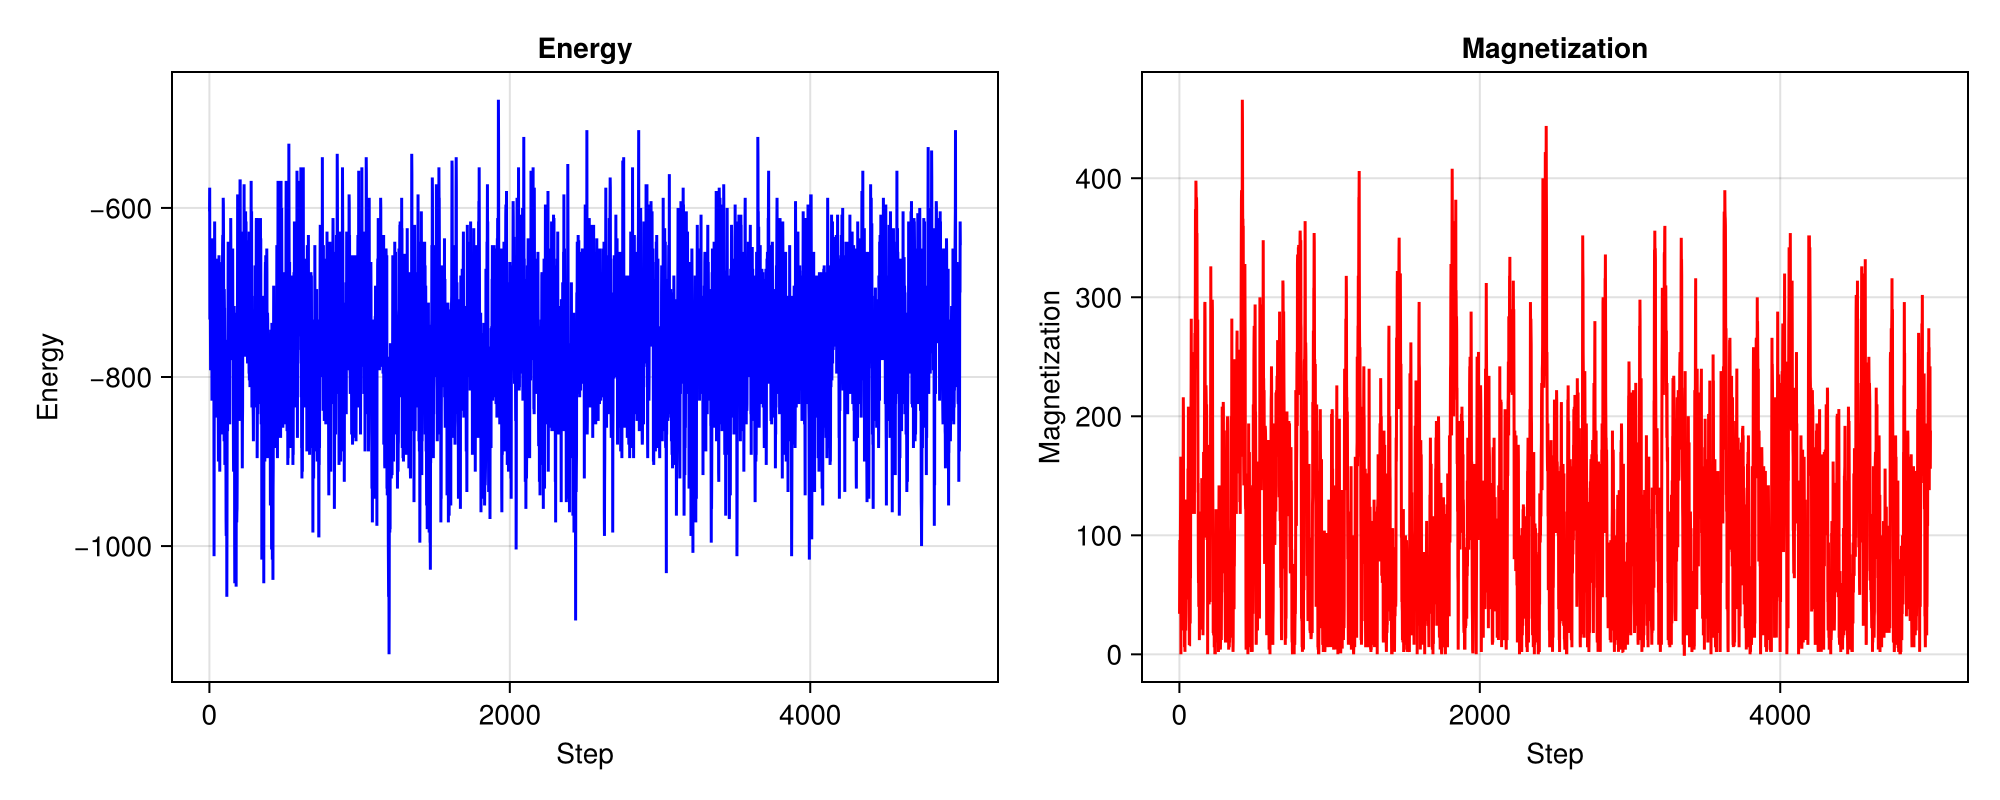

In [7]:
plot_energy_mag(m_nrg, m_mag)

Tau: 3.2555555362705113

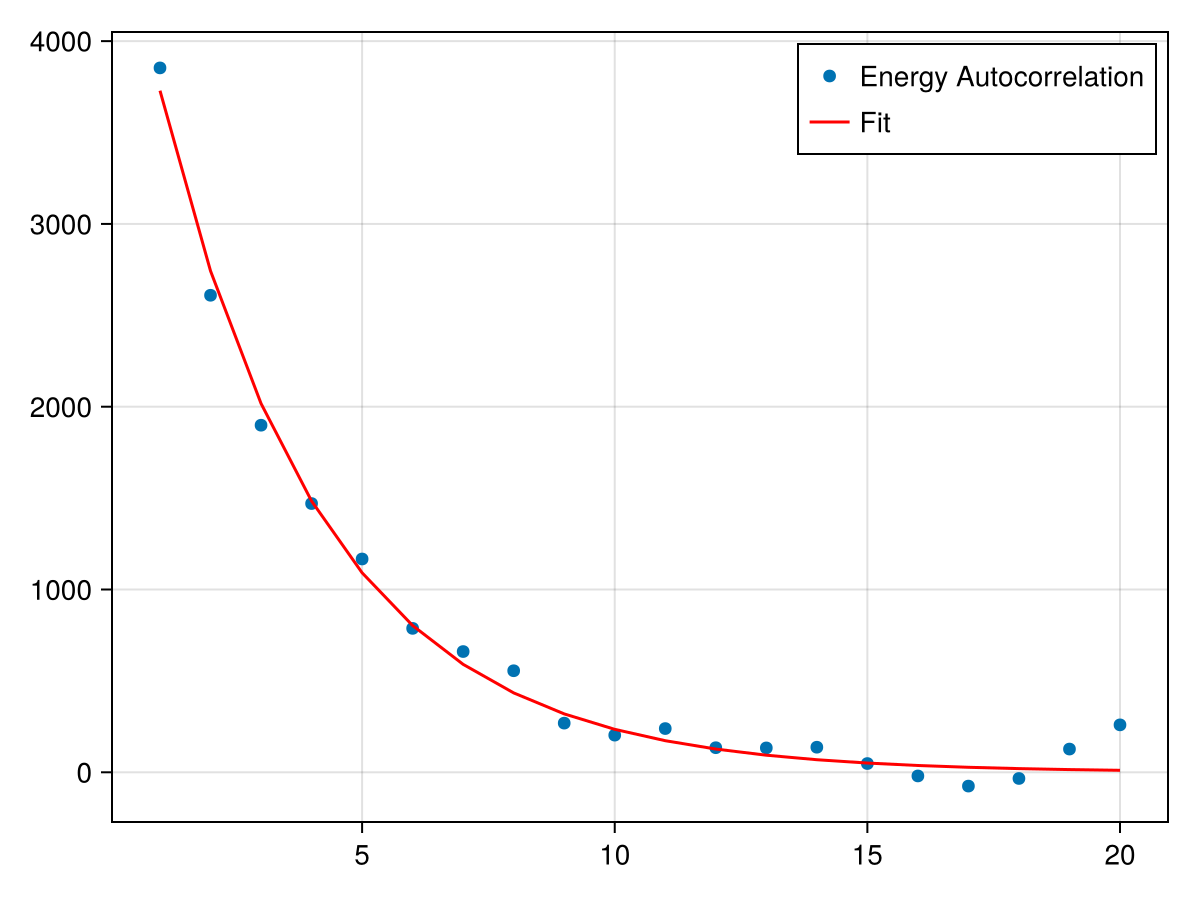

In [8]:
plot_autocorr(m_nrg, 1_000, 20)

### Wolff

In [9]:
simple_monte_carlo(grid_size=grid_size, T=T, N=1, mc_algorithm=wolff_step);

In [10]:
@time w_nrg, w_mag = simple_monte_carlo(grid_size=grid_size, T=T, N=10_000, mc_algorithm=wolff_step)

  0.073616 seconds (194.13 k allocations: 38.686 MiB, 16.74% gc time)


([-10.0, 8.0, 4.0, 8.0, 18.0, 40.0, 42.0, 32.0, 36.0, 38.0  …  -60.0, -56.0, -48.0, -50.0, -108.0, -112.0, -96.0, -22.0, -28.0, -26.0], [-0.022, -20.022, -20.022, -20.022, -44.022, -80.02199999999999, -80.02199999999999, -84.02199999999999, -92.02199999999999, -100.02199999999999  …  -620.0219999999999, -612.0219999999999, -608.0219999999999, -600.0219999999999, -596.0219999999999, -600.0219999999999, -608.0219999999999, -608.0219999999999, -604.0219999999999, -600.0219999999999])

much less steps are needed to reach equilibrium. the runtime is slower but the number of steps isn't really comparable, because the wolff algorithm flips a lot more spins per step.

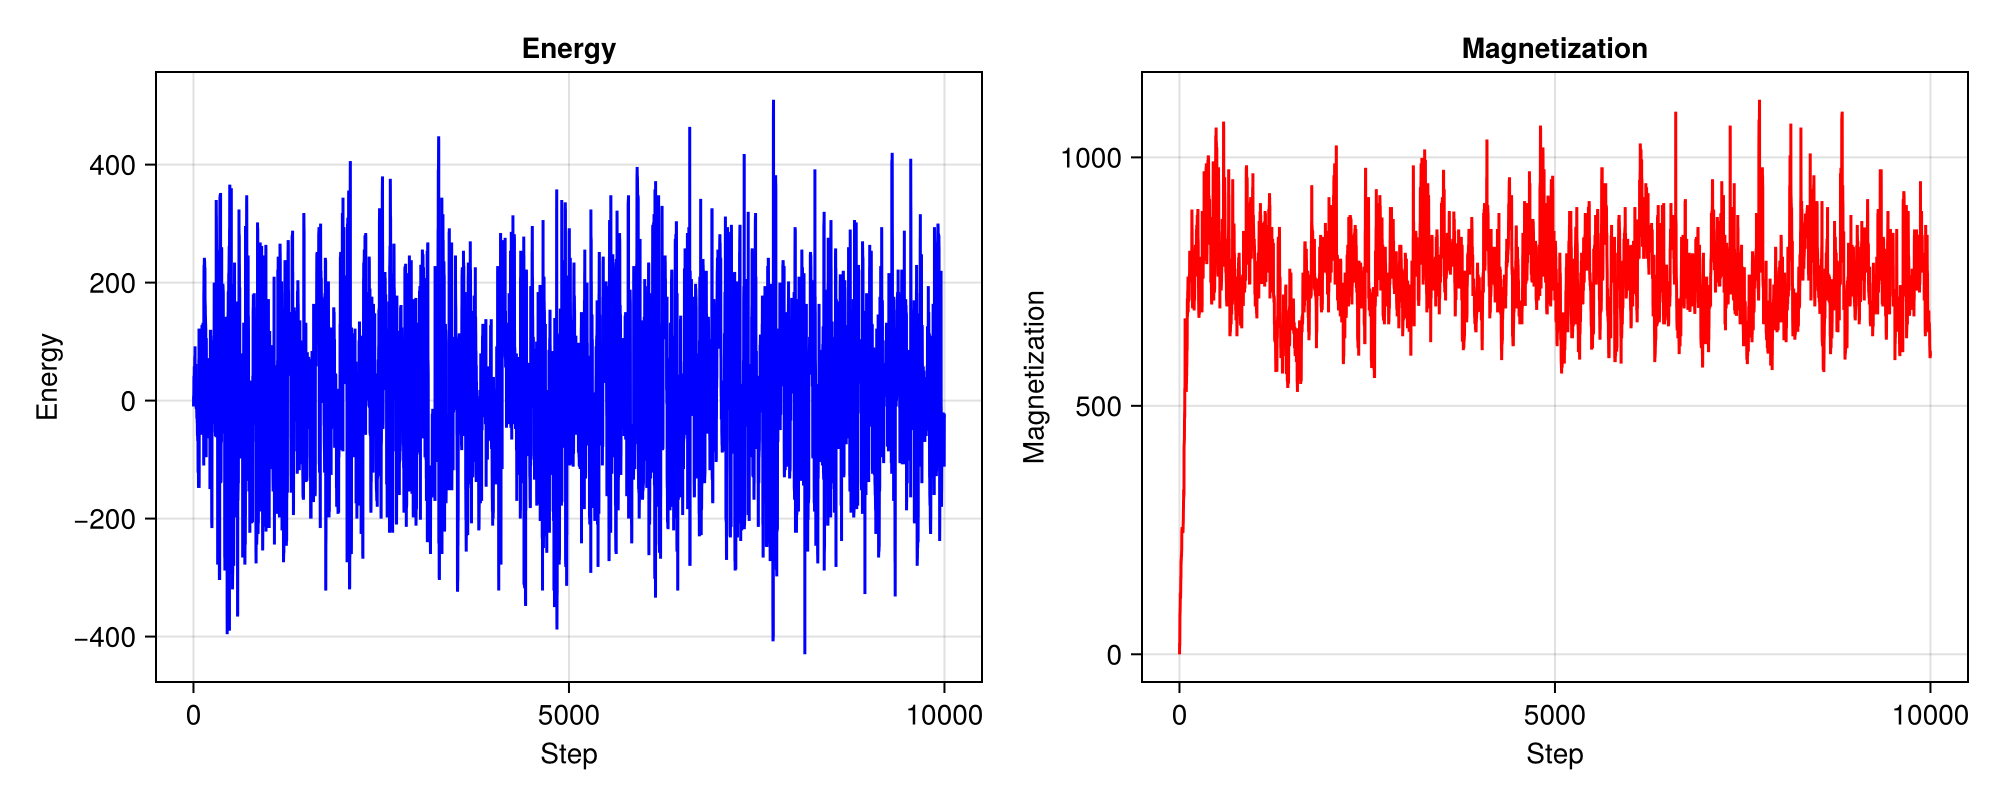

In [11]:
plot_energy_mag(w_nrg, w_mag)

Tau: 4.770008942429445

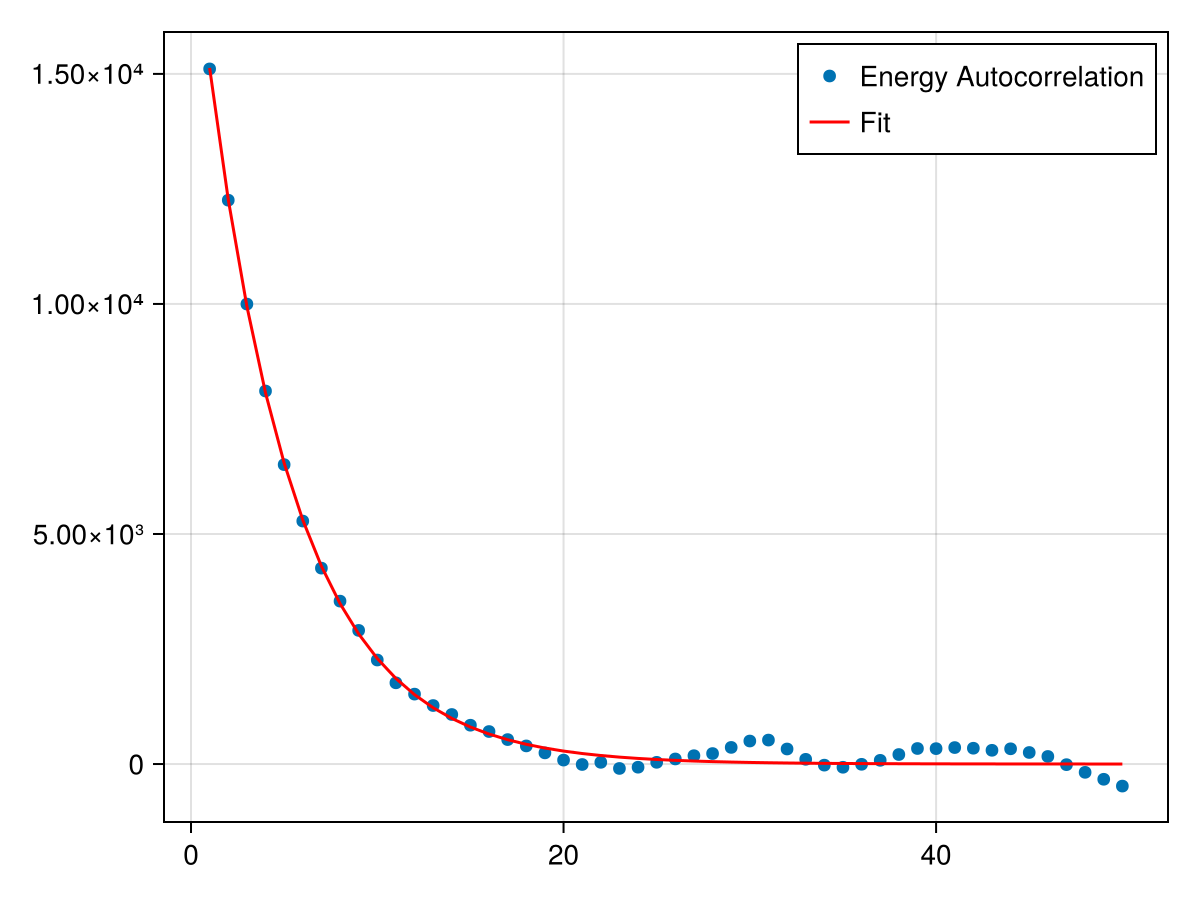

In [12]:
plot_autocorr(w_nrg, 1_000, 50)

the autocorrelation time is much smaller

## Fließbandarbeit 

In [13]:
linfit(x, p) = x .* p[1] .+ p[2]

function get_ac_time(energy; N_Thermalize::Int=50_000, max_lag::Int=1_000)
    ac = autocorr(energy[N_Thermalize:end], max_lag=max_lag)

    # if the autocorrelation gets negative, remove the values after that
    if any(ac .< 0)
        ac = ac[1:findfirst(ac .< 0)-1]
    end

    ac_log = log.(ac)
    time = collect(1:length(ac_log))

    fit = lsq.curve_fit(linfit, time, ac_log, [1., 1.])
    return 1/abs(fit.param[1])
end

function gather_times(;grid_size::Int=10, T::Float64=5., N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step)
    run_times = Vector{Float64}(undef, N_Tests)
    autocorr_times = Vector{Float64}(undef, N_Tests)
    for i in 1:N_Tests
        run_times[i]  = @elapsed energy, mag = simple_monte_carlo(grid_size=grid_size, T=T, N=N_Sweeps, mc_algorithm=mc_algorithm)
        autocorr_times[i] =  get_ac_time(energy; N_Thermalize=N_Thermalize, max_lag=max_lag)
    end
    mc_speed = N_Sweeps ./ (run_times .* autocorr_times)
    return mean(run_times), mean(autocorr_times), mean(mc_speed) 
end

gather_times (generic function with 1 method)

In [14]:
gather_times(grid_size=10, T=5., N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)

(0.039967547799999996, 2410.319488504552, 6558.97650579591)

In [15]:
# multiple temperatures
function ensemble_times(grid_size::Int=10, temps::Array{Float64}=[3.51,4.51,5.51]; N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step) 
    run_times = Vector{Float64}(undef, length(temps))
    autocorr_times = Vector{Float64}(undef, length(temps))
    mc_speeds = Vector{Float64}(undef, length(temps))
    Threads.@threads for (i, T) in collect(enumerate(temps))
        run_times[i], autocorr_times[i], mc_speeds[i] = gather_times(grid_size=grid_size, T=T, N_Sweeps=N_Sweeps, N_Thermalize=N_Thermalize, max_lag=max_lag, N_Tests=N_Tests, mc_algorithm=mc_algorithm)
    end
    return run_times, autocorr_times, mc_speeds
end

function ensemble_times_table(temps::Vector{Float64}, grid_size::Int, run_times::Vector{Float64}, autocorr_times::Vector{Float64}, mc_speeds::Vector{Float64})
    grid_sizes = [grid_size for i in 1:length(temps)]
    data = hcat(temps, grid_sizes, run_times, autocorr_times, mc_speeds)
    return pt.pretty_table(data , header=["Temperature", "Grid Size", "Run Time", "Autocorrelation Time", "MC Speed"])
end

# multiple grid sizes

function ensemble_times(grid_sizes::Array{Int}=[8, 10, 12], temp::Float64=5.; N_Sweeps::Int=1_000,N_Thermalize::Int=1_000, max_lag::Int=50, N_Tests::Int=10, mc_algorithm::Function=metropolis_step) 
    run_times = Vector{Float64}(undef, length(grid_sizes))
    autocorr_times = Vector{Float64}(undef, length(grid_sizes))
    mc_speeds = Vector{Float64}(undef, length(grid_sizes))
    Threads.@threads for (i, grid_size) in collect(enumerate(grid_sizes))
        run_times[i], autocorr_times[i], mc_speeds[i] = gather_times(grid_size=grid_size, T=T, N_Sweeps=N_Sweeps, N_Thermalize=N_Thermalize, max_lag=max_lag, N_Tests=N_Tests, mc_algorithm=mc_algorithm)
    end
    return run_times, autocorr_times, mc_speeds
end

function ensemble_times_table(temp::Float64, grid_sizes::Vector{Int}, run_times::Vector{Float64}, autocorr_times::Vector{Float64}, mc_speeds::Vector{Float64})
    temps = [temp for i in 1:length(grid_sizes)]
    data = hcat(temps, grid_sizes, run_times, autocorr_times, mc_speeds)
    return pt.pretty_table(data, header=["Temperature", "Grid Size", "Run Time", "Autocorrelation Time", "MC Speed"])
end

ensemble_times_table (generic function with 2 methods)

### Temperatures

In [16]:
temps = [3, 3.5, 4, 4.5, 5, 5.5, 6]
grid_size = 10;

In [17]:
# metropolis
ensemble_times_table(temps, grid_size, ensemble_times(grid_size, temps, N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         3.0 │      10.0 │ 0.0680512 │              1306.29 │  6183.29 │
│         3.5 │      10.0 │ 0.0879419 │              2091.51 │  3428.49 │
│         4.0 │      10.0 │ 0.0730059 │              3340.19 │  2515.73 │
│         4.5 │      10.0 │ 0.0787793 │              10345.5 │  716.782 │
│         5.0 │      10.0 │ 0.0391882 │              2386.14 │   5609.0 │
│         5.5 │      10.0 │  0.067167 │               1466.8 │  6972.35 │
│         6.0 │      10.0 │  0.120724 │              1260.61 │  7885.34 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘


In [18]:
# wolff
ensemble_times_table(temps, grid_size, ensemble_times(grid_size, temps, N_Sweeps=10_000, N_Thermalize=1_000, max_lag=50, N_Tests=5, mc_algorithm=wolff_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         3.0 │      10.0 │   4.49808 │                  1.0 │  2395.19 │
│         3.5 │      10.0 │   4.25558 │                  1.0 │  2498.15 │
│         4.0 │      10.0 │   3.36391 │                  1.0 │   3238.7 │
│         4.5 │      10.0 │    1.3367 │              1.09347 │  11704.6 │
│         5.0 │      10.0 │ 0.0941236 │              7.80975 │  14914.6 │
│         5.5 │      10.0 │ 0.0445718 │              13.8633 │  17769.2 │
│         6.0 │      10.0 │ 0.0359531 │              24.4181 │  11470.6 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘


### Lattice sizes

In [19]:
temp = 5.0
grid_sizes = [5, 8, 10, 12, 15]

5-element Vector{Int64}:
  5
  8
 10
 12
 15

In [20]:
# metropolis
ensemble_times_table(temp, grid_sizes, ensemble_times(grid_sizes, temp, N_Sweeps=500_000, N_Thermalize=50_000, max_lag=5_000, N_Tests=5, mc_algorithm=metropolis_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         5.0 │       5.0 │ 0.0722931 │              483.442 │  23304.3 │
│         5.0 │       8.0 │  0.072988 │              2297.25 │   3909.0 │
│         5.0 │      10.0 │ 0.0536028 │              2796.69 │  3556.55 │
│         5.0 │      12.0 │ 0.0764124 │              3892.21 │   2086.9 │
│         5.0 │      15.0 │ 0.0923177 │              4910.29 │  1317.61 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘


In [21]:
# wolff
ensemble_times_table(temp, grid_sizes, ensemble_times(grid_sizes, temp, N_Sweeps=10_000, N_Thermalize=1_000, max_lag=50, N_Tests=5, mc_algorithm=wolff_step)...)

┌─────────────┬───────────┬───────────┬──────────────────────┬──────────┐
│ Temperature │ Grid Size │  Run Time │ Autocorrelation Time │ MC Speed │
├─────────────┼───────────┼───────────┼──────────────────────┼──────────┤
│         5.0 │       5.0 │ 0.0750828 │              1.53537 │  94811.8 │
│         5.0 │       8.0 │ 0.0904414 │              6.29089 │  39759.5 │
│         5.0 │      10.0 │ 0.0872488 │              8.22167 │  20752.9 │
│         5.0 │      12.0 │ 0.0907292 │              10.5426 │  11045.2 │
│         5.0 │      15.0 │ 0.0887463 │               17.635 │  6728.96 │
└─────────────┴───────────┴───────────┴──────────────────────┴──────────┘
